## Description

This notebook uses the previously extracted sentence embeddings to train machine learning models in predicting a company's average rating (on Kununu.com/de) based on their job postings on stepstone.com/de.

Furthermore, another classification model is trained to recognise the industry of a company based on it's job posting (through their sentence embeddings)

## Import Packages
Neccessary packages include:
 - Packages to handle data frames (pandas, numpy)
 - Packages to handle texts (re, string)
 - Packages for model selection (Kfold, StratifiedKFold, GridSearchCV)
 - Packages for machine learning models (Ridge, SVR, KNeighborsRegressor, RandomForestRegressor, etc.)
 - Packages for plotting (seaborn, matplotlib)

In [1]:
import pandas as pd
import numpy as np
import re
import os
from scipy.stats import pearsonr

#Preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV

#model
from sklearn.linear_model import Ridge, RidgeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

#plots
import seaborn as sns
import matplotlib.pyplot as plt

## Functions

In [2]:
#plot a heatmap and return formatted dataframe
def heatPlot(df, n, names, sector):
    if not os.path.exists("../Images/further analysis/"): os.makedirs("../Images/further analysis/")
    heatmap = pd.DataFrame(np.full((n,n),0), columns=names, index = names) #columns: predicted, #index: observed
    
    #count how many data points for every combination of observed/predicted
    predicted = df.prediction.values
    observed = df.actual.values
    for i in range(n):
      for j in range(n):
        heatmap.iloc[i,j] = (predicted[observed == i] == j).sum()
      heatmap.iloc[i,:] = heatmap.iloc[i,:]/sum(heatmap.iloc[i,:])*100
    heatmap.index.name = 'observed'
    heatmap.columns.name = 'predicted'
    
    plt.figure(figsize=(16,10), dpi=200)
    sns.heatmap(heatmap, annot=True, fmt="g", cmap='viridis')
    plt.ylabel("observed industries")
    plt.xlabel("predicted industries")
    plt.title("Heatmap: observed over predicted industry types")
    plt.xticks(rotation=90)
    plt.tight_layout()
#     plt.show()
    plt.savefig("../Images/further analysis/heatmap_industry_prediction_" + sector + ".png") #save heatmap
    return heatmap

## Predict job ratings from job postings

Choose what kind of job positions should be considered for the predictions. <br>
Choose what kind of prediction model should be used (Ridge as standard):

    - Choose between "all" (for employee, manager and intern), "employee" and "manager"
    - Choose between Ridge, SVR, KNN and RandomForest

In [3]:
p = 0          #0: all, 1: employee, 2: manager
m_select = 1   #0:SVR, #1: Ridge, #2 KNN, #3 RandomForest | best model is Ridge

### Run Prediction Models
Train the models using 5-Fold Cross Validation. <br>
Save the results including various other information (sample size, number of postings, number of ratings, etc.) in the respective folder.

In [49]:
""" Data Imports """ #try different text section embeddings

kununu_df   = pd.read_csv("../raw_data/kununu_df.csv", encoding="utf-8-sig", index_col=0)
kununu_df.Org = kununu_df.Org.apply(lambda x: re.sub("\.","",str(x).lower().lstrip().rstrip()))
sections = ["all","einleitung", "anforderungen", "aufgaben", "wir_bieten", "sonstiges"]
scores   = [x for x in kununu_df.columns.values if "Score" in x]
pos = ["all", "employee", "manager"]
positions = {"all": ["employee", "manager", "intern"], "employee": ["employee"], 
             "manager": ["manager"]} #filter by position -> nur fest angestellte, keine Lehrtätigkeit (da dies nicht in den postings widergespiegelt wird)
position = positions[pos[p]]

#frame with overview of performance across all model types
columns = ["text", "score","corr", "p-value", "N"]
performance_overview = pd.DataFrame(np.full((len(sections)*len(scores), len(columns)), np.nan), columns = columns)
performance_overview.text = np.repeat(sections, len(scores))
performance_overview.score = scores* len(sections)

#frames for descriptive statistics (how many embeddings? how many ratings? how many positions, etc) -> meta information
deskr_emb_df = pd.DataFrame(np.full((len(sections), 3), np.nan), columns = ["test_section", "no_postings", "no_companies"])
deskr_emb_df.test_section = sections
deskr_pos_df = pd.DataFrame(np.full((kununu_df.Position.drop_duplicates().shape[0], 2), np.nan), columns = ["position", "no_people"])
deskr_pos_df.position = kununu_df.Position.drop_duplicates().values
deskr_score_df = pd.DataFrame(np.full((len(scores), 3), np.nan), columns = ["score","no_ratings", "considered_ratings"])
deskr_score_df.score = scores

""" Model Selection """

#list of predictin models
model_list = [SVR(), Ridge(), KNeighborsRegressor(), RandomForestRegressor()]    

""" Predictions """ 

model = model_list[m_select] #choose model
kf = KFold(n_splits = 5, shuffle = True, random_state=0) #Cross Validation, 5-Fold

for i, section in enumerate(sections):
    # section = "anforderungen"
    embeddings = pd.read_csv("../data/embeddings/embeddings" + "_" + section + "_1_1.csv", index_col = 0) #1: USE, #1: average each sentence in the posting
    company_embeddings = embeddings.groupby("Org").mean() #create "company" embeddings by averaging all postings of a company
    final_kununu_df = kununu_df[kununu_df.Org.isin(embeddings.Org.drop_duplicates()) & (kununu_df.Position.isin(position))]
    
    #save meta information
    deskr_pos_df.no_people = kununu_df[kununu_df.Org.isin(embeddings.Org.drop_duplicates())].Position.value_counts().values
    deskr_score_df.no_ratings = final_kununu_df[scores].count().values
    deskr_emb_df.iloc[i,1] = embeddings.shape[0]
    deskr_emb_df.iloc[i,2] = company_embeddings.shape[0]
    
    for j, score in enumerate(scores): #investigate which scores to look into -> look into all significant ones
        # print(score)
        #filter out companies with less then 4 ratings for the respective rating type and positions
        nr_orgs = final_kununu_df.groupby("Org")[score].count() 
        orgs = nr_orgs[nr_orgs>29].index.values
        deskr_score_df.iloc[j,2] = final_kununu_df[final_kununu_df.Org.isin(orgs)][scores].count().values[j]
        deskr_pos_df[score + "_no_people"] = kununu_df[kununu_df.Org.isin(embeddings.Org.drop_duplicates()) & kununu_df.Org.isin(orgs)].Position.value_counts().values
        filtered_scores = final_kununu_df.groupby("Org")[score].mean().reindex(company_embeddings.index).dropna()
        filtered_scores = filtered_scores.loc[orgs]
        
        """ Train Model """
        
        #preprocessing
        X = company_embeddings.loc[filtered_scores.index,:].values #remove embeddings that have no score on chosen position
        y = filtered_scores.values #by company (mean)
        
        X_pca = PCA(0.90, random_state=0).fit_transform(X) #reduce dimension
        
        performance = []
        total_preds = pd.DataFrame(np.full((1, len(y)), np.nan), columns = orgs)
        for k, (tr, ts) in enumerate(kf.split(X_pca, y)): # cross validation
            X_train, X_test = X_pca[tr], X_pca[ts]
            y_train, y_test = y[tr], y[ts]
            
            y_pred = model.fit(X_train, y_train).predict(X_test)
            corr = np.round(pearsonr(y_pred, y_test),3)
            total_preds.iloc[0, ts] = y_pred #save in dataframe (all test fold predictions are stored here)
            performance.append(corr)
            
        performance_df = pd.DataFrame(performance, index = ["Fold " + str(j) for j in range(k+1)], columns = ["corr", "p-value"])        
        performance_overview.iloc[i*len(scores)+j,2:-1] = pearsonr(total_preds.values[0], y)
        performance_overview.iloc[i*len(scores)+j, -1] = len(y)

#save in respective folder
if not os.path.exists("../metadata/"): os.makedirs("../metadata/")
writer = pd.ExcelWriter("../metadata/performance_overview_" + pos[p] + ".xlsx", engine = 'xlsxwriter')
performance_overview.to_excel(writer, sheet_name = 'performance')
deskr_emb_df.to_excel(writer, sheet_name = 'stats_embeddings')
deskr_pos_df.to_excel(writer, sheet_name = 'stats_positions')
deskr_score_df.to_excel(writer, sheet_name = 'stats_scores')
writer.save()
writer.close()

D:\Programmes\Anaconda\envs\bachelor\lib\site-packages\xlsxwriter\workbook.py:329: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")


## Predict industry labels from job postings

In [6]:
#choose which text type to consider (einleitung, all, aufgaben, anforderungen, wir_bieten, sonstiges)
sector = "einleitung" #highest performance for introduction

#Choose the type of prediction model
m_select = 1 #0:SVR, #1: Ridge, #2 KNN, #3 RandomForest

### Run prediction models

In [7]:
""" Import data """

embeddings = pd.read_csv("../data/embeddings/embeddings_" + sector + "_1_1.csv", index_col = 0) #all postings
company_embeddings = embeddings.groupby("Org").mean()
ratings = pd.read_csv("../raw_data/kununu_df.csv", index_col = 0)
cols = [x for x in ratings.columns if "score" in x.lower()]
cols.append("Org")

#overview of number of postings per company
nr_ratings = ratings[cols].groupby("Org").count()
orgs = nr_ratings[nr_ratings.Overall_Score > 3].index
company_ratings = ratings[cols].groupby("Org").mean().loc[orgs,:]
industries = pd.read_csv("../data/misc/industries_manuel_fix.csv", index_col=0) #list with industry types for each company

comp_industries = industries.copy()
comp_industries.search_name = comp_industries.search_name.apply(lambda x: str(x).lower())
company_embeddings = company_embeddings.merge(comp_industries, left_index=True, right_on="search_name").drop("kununu_name", 1)
company_embeddings.set_index('search_name', inplace=True)

""" Data Preprocessing """

X = company_embeddings.iloc[:,:-5] #comp. embeddings
X_pca = PCA(0.90, random_state=0).fit_transform(X)
y_raw = company_embeddings.iloc[:,-1] #industry labels

n = len(np.unique(y_raw))
ind_names = np.unique(y_raw) #list of industry labels
name_to_nr = {key:val for key,val in zip(np.unique(y_raw), range(n))} #convert to numbers for classifier
nr_to_name = {val:key for key,val in zip(np.unique(y_raw), range(n))} #convert to names for plots
y = np.array([name_to_nr[x] for x in y_raw])

""" Model Parameters (for tuning) """
kf = StratifiedKFold(n_splits = 5, shuffle = True, random_state=0) #distribution might be skewed

#SVC
kernel1 = ["rbf", "sigmoid", "linear"] #-> probably rbf, seems very stable regarding "C"
gammas = np.logspace(-3, 2, 6) #seems to be stable towards gamma (0.01)
class_weight = [{0:26, 1:23, 2:8, 3:25, 4:8, 5:87, 6:8, 7:23}] #adjust weights to class distribution -> seems to always favor "balanced"
class_weight2 = ["balanced", "balanced_subsample", class_weight[0]] #adjust weights to class distribution -> seems to always favor "balanced"
max_iter = [100000]

#RandomForest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)] #Number of trees in random forest, converges~200
max_depth = [int(x) for x in np.linspace(1, 100, num = 11)] #always 10, seems stable -> keep default
max_depth.append(None)
max_leaf_nodes = [int(x) for x in np.linspace(10,100,6)] #around 25 best
max_samples = [0.5,0.9, None] #None probably best

#params and models list:
C = np.logspace(-3, 5, 9)
rg_grid  = {"alpha": C}
svc_grid = {"C": C, "max_iter": max_iter, "kernel": kernel1, "gamma": gammas, "class_weight": class_weight, "random_state": [0]}#, "probability":[True] #slow when proba=True
knn_grid = {"n_neighbors": [1,2,3,4,5,10,15,30,50,100]}
rf_grid  = {"max_leaf_nodes": [50], "n_estimators": [150], "random_state": [0], "n_jobs":[-1], "max_features": [x for x in np.linspace(0.2,0.8,8)]}

model_list = [(SVC(), svc_grid), (RidgeClassifier(), rg_grid), (KNeighborsClassifier(), knn_grid), (RandomForestClassifier(), rf_grid)]    

""" Predictions """

model = model_list[m_select][0]
params = model_list[m_select][1]

performance = []
total_pred = pd.DataFrame(np.full((len(y), 2), -1), index = company_embeddings.index, columns = ["prediction", "actual"])
total_pred.iloc[:, 1] = y
for k, (tr, ts) in enumerate(kf.split(X_pca, y)): #cross validation
    #include gridsearch
    X_train, X_test = X_pca[tr], X_pca[ts]
    y_train, y_test = y[tr], y[ts]
    best_model = GridSearchCV(model, params, cv=kf, scoring = "balanced_accuracy") #tuning
    best_model.fit(X_train, y_train)

    y_pred = best_model.predict(X_test) # heatmap?
    acc = (y_pred == y_test).sum()/len(y_pred)
    performance.append(acc)
    total_pred.iloc[ts, 0] = y_pred

performance_df = pd.DataFrame(performance, index = ["Fold " + str(j) for j in range(k+1)], columns = ["total_acc"])
print(performance_df.mean(0))

total_acc    0.678205
dtype: float64


### Plots
Show a heatmap for the industry label prediction. <br>
Show bar plots as summary of the prediction performance.

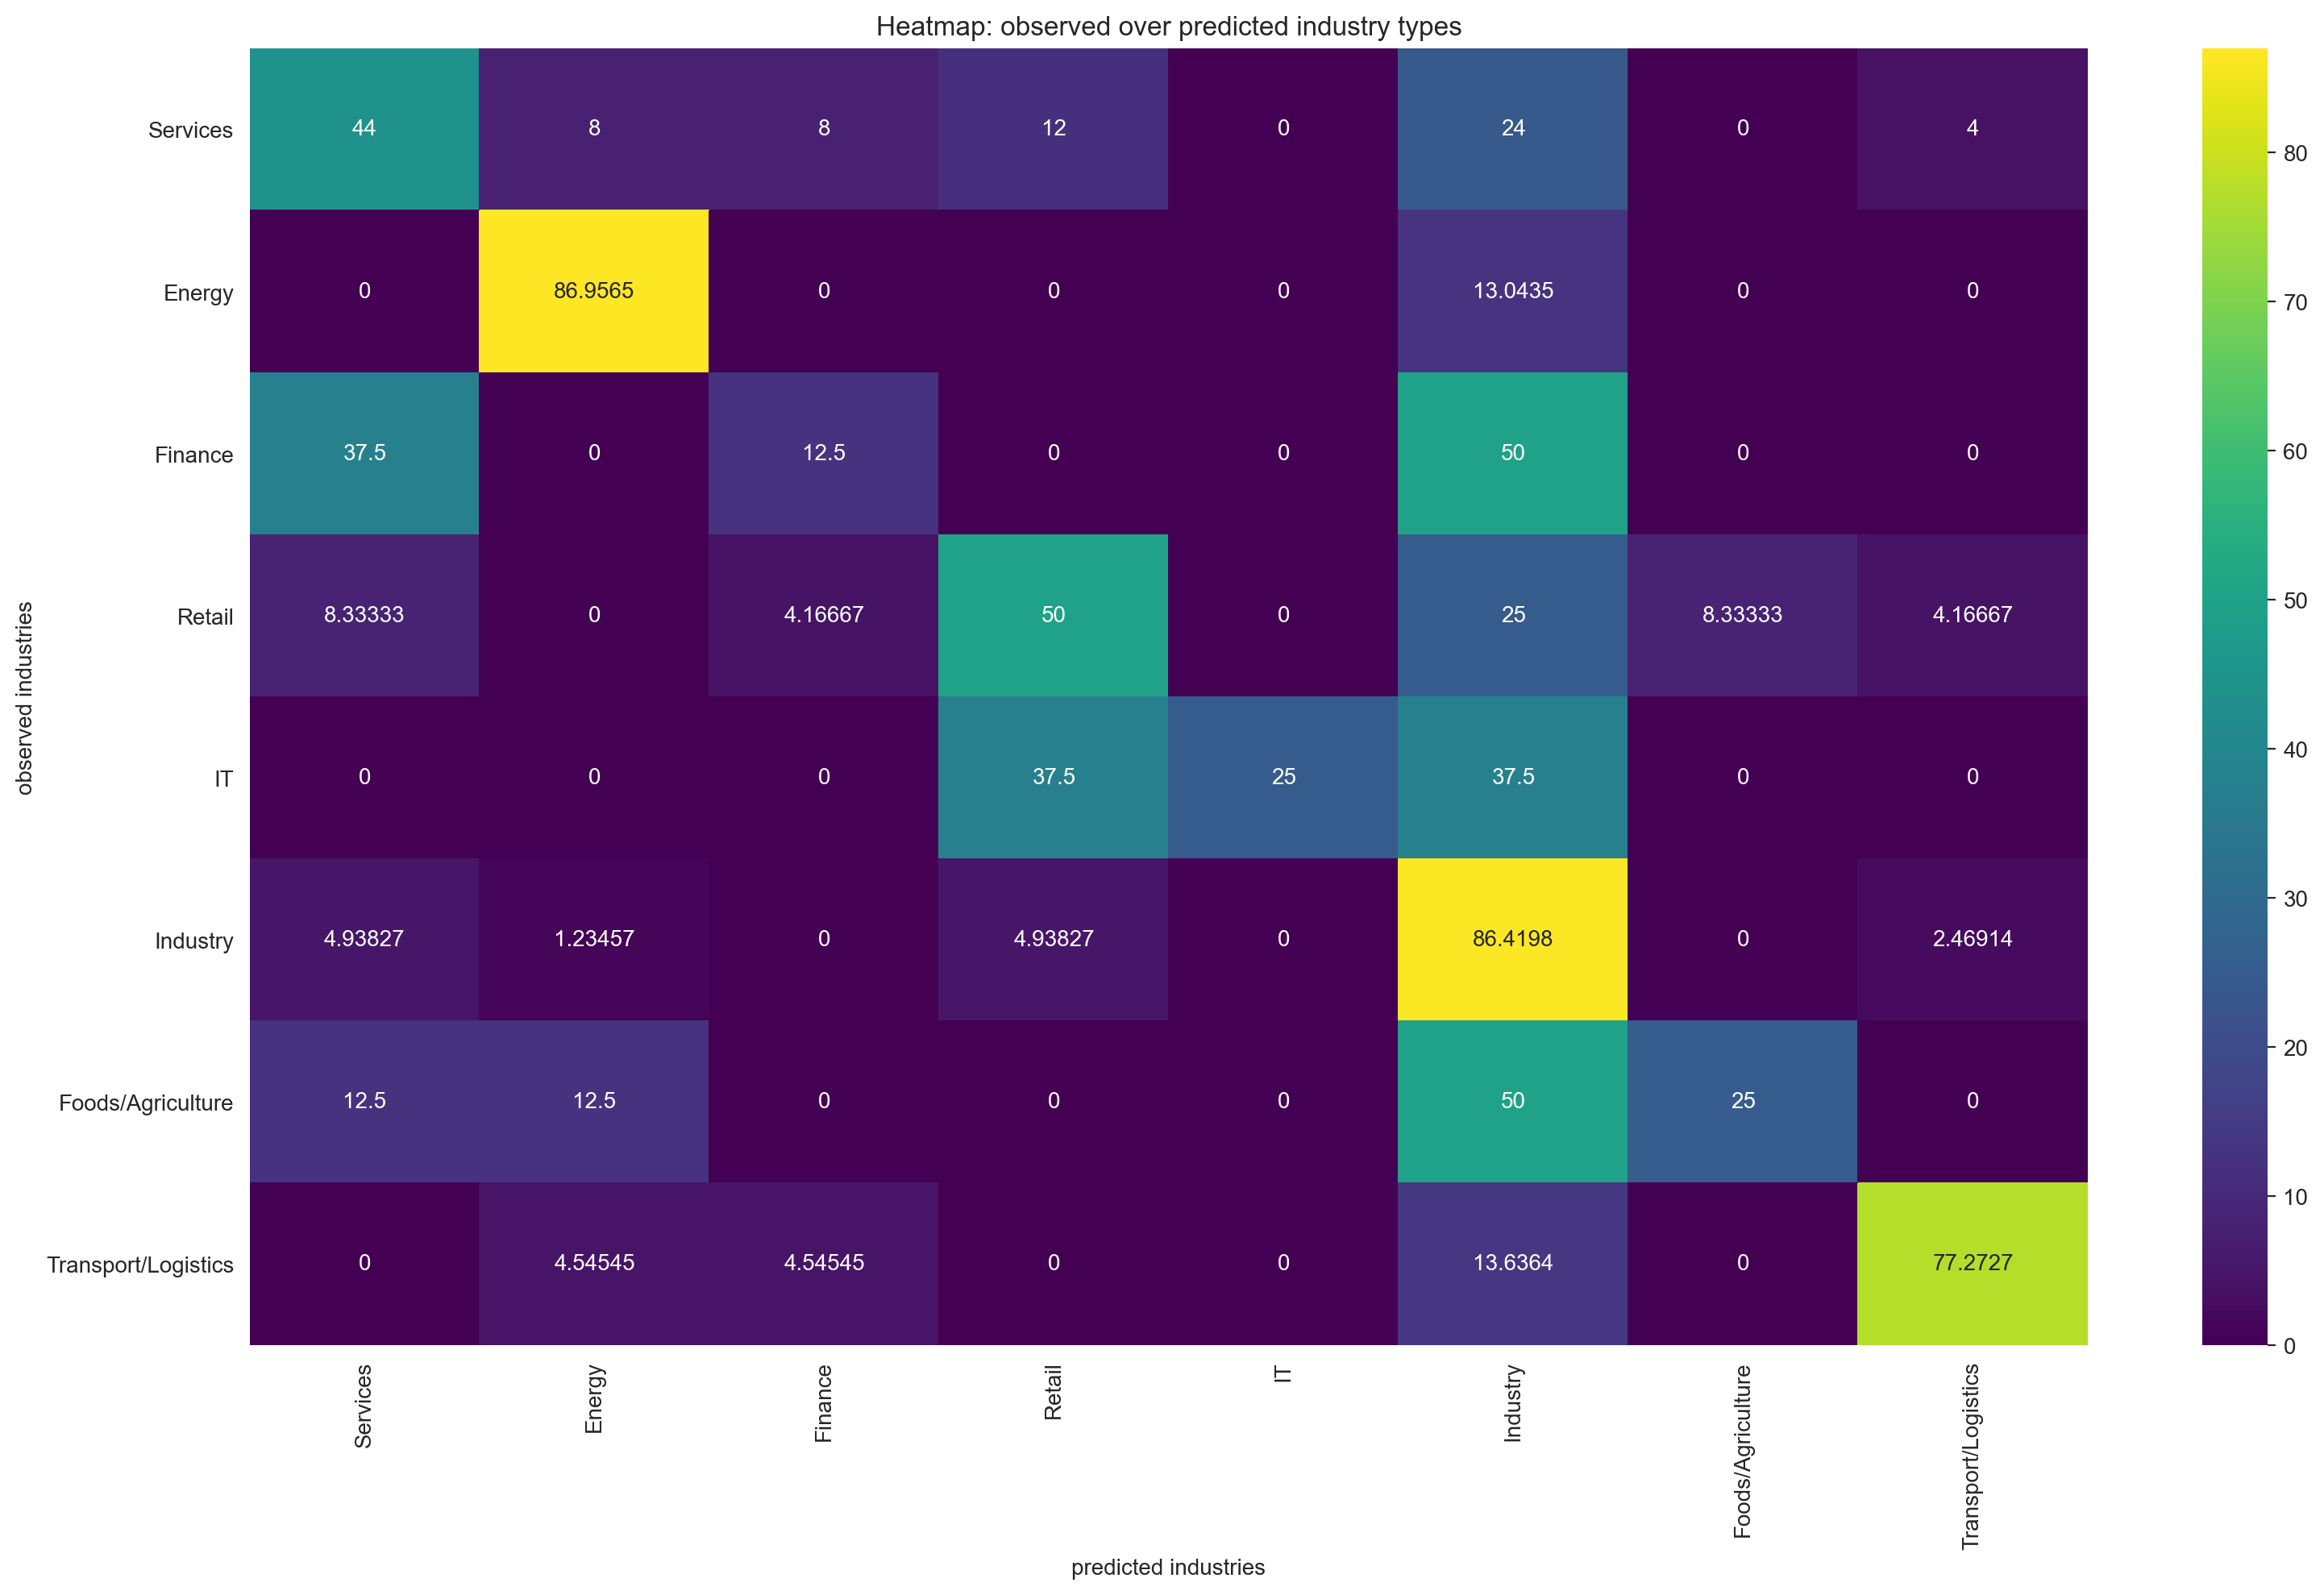

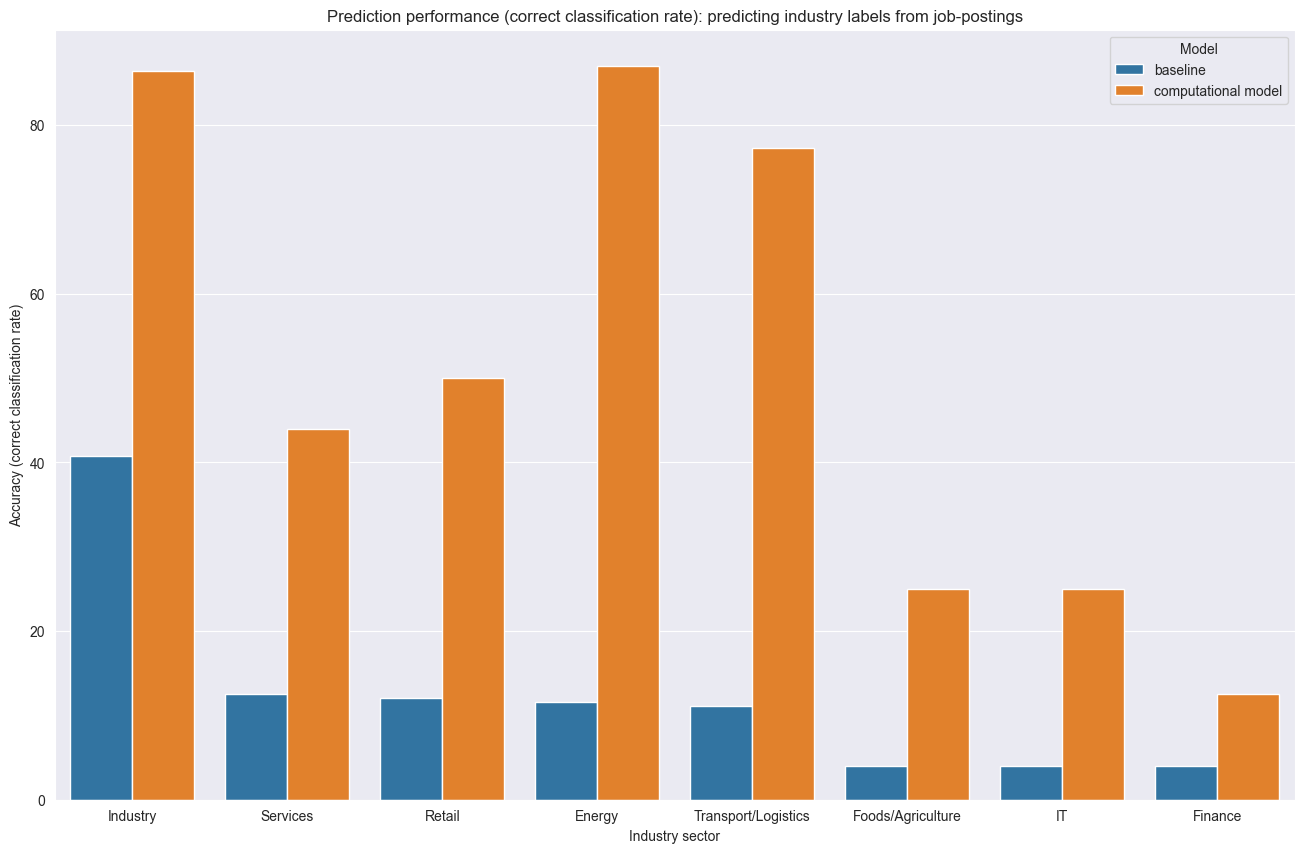

In [32]:
""" Plots """
translate_dict = {"IT": "IT", "Industrie": "Industry", "Dienstleistung": "Services", "Handel": "Retail", "Finanz": "Finance",
                 "Transport/Verkehr/Logistik": "Transport/Logistics", "Nahrungsmittel/Landwirtschaft": "Foods/Agriculture", "Energie": "Energy"}

#Heatmap
trans_names = [translate_dict[x] for x in ind_names]
heatmap = heatPlot(total_pred, n, trans_names, sector)

# create plots for the baselines
baseline_df = pd.DataFrame(pd.value_counts(y_raw)/len(y_raw))*100 #baseline as class distribution (most trivial model would simply assign the majority class for each data point)
baseline_df.reset_index(level=0, inplace=True)
baseline_df.columns = ["sector", "baseline"]
baseline_df.sector = baseline_df.sector.replace(translate_dict)
accuracy = [heatmap.loc[sec,sec] for sec in baseline_df.sector]
baseline_df["computational model"] = accuracy
baseline_plot = pd.melt(baseline_df, id_vars='sector', value_vars=['baseline', 'computational model'], var_name="Model")

plt.figure(figsize=(16,10))
plt.style.use("default")
sns.set_style("darkgrid")
sns.barplot(data=baseline_plot, x="sector", y="value", hue = "Model")
plt.xlabel("Industry sector")
plt.ylabel("Accuracy (correct classification rate)")
plt.title("Prediction performance (correct classification rate): predicting industry labels from job-postings")
            
plt.savefig("../Images/further analysis/performance_industry_prediction_" + sector + ".png") #save bar plots